In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import image
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

In [2]:
import scipy.io

mat_data = scipy.io.loadmat('data/ex4data1.mat')
mat_weights = scipy.io.loadmat('data/ex4weights.mat')

X = mat_data['X']
y = mat_data['y']
weights_course = np.concatenate([mat_weights['Theta1'].flatten(),
                                mat_weights['Theta2'].flatten()],
                                axis = 0)

In [3]:
class NeuralNetwork():
    """
    Instance a neural network with user-defined configuration 
    and sigmoid activation function. 
    
    Parameters:
    -----------
    layers_size : a list containing numbers of artificial neurons
                  in each layer including output and input layers.
    X_dat : a training set features of type pandas or numpy.array.
    y_data: labels of each training example
    
    """
    def __init__(self, X_data, y_data, layers_size):
        self.X = X_data if type(X_data) == np.ndarray\
                    else np.array(X_data, dtype = 'float32')
        self.y = y_data if type(y_data) == np.ndarray\
                    else np.array(y_data)
        self.labels = np.unique(self.y)
        self.y_mat = (self.labels == self.y) * 1
        self.lsize = layers_size
        self.net_input = None                                   # list of input data for each layer except the first one
        self.net_output = None                                  # list of output data of each layer
        self.net_weights_trained = None                         # flatten array of trained weights
        
    def AddBias(self, x, value):
        if x.ndim > 1:
            return np.insert(x, 0, value, axis = 1)
        return np.insert(x, 0, value, axis = 0)
    
    def Sigmoid(self, z):
        return 1/(1 + np.exp(-z))
    
    def SigmoidGrad(self, z):
        return self.Sigmoid(z) * (1 - self.Sigmoid(z))
    
    def RandomWeights(self):
        """
        Create an array of random weights lying in the range
        [-eps, + eps], where choosing of eps refers to Xavier 
        weight initialization.  
        
        """
        nlayers = len(self.lsize)
        res = np.array([])
        for i in range(nlayers - 1):
            clsize = self.lsize[i] + 1
            plsize = self.lsize[i+1]
            eps = np.sqrt(6)/np.sqrt(clsize + plsize)
            weights = np.random.rand(clsize * plsize) 
            weights = weights * 2 * eps - eps
            res = np.concatenate((res, weights.flatten()),
                                axis = 0) 
            
        return res
    
    def Weights(self, net_weights, layer):
        """"
        Reshape a slice of flatten weights array to get 
        a weight matrix between layer and layer+1.
        
        """
        left = 0
        right = 0
        for i in range(layer):
            clsize = self.lsize[i+1]
            plsize = self.lsize[i] + 1
            right += clsize * plsize
            if i == layer-1:
                weights = net_weights[left:right]
            left += plsize * clsize
            
        return weights.reshape(clsize, plsize).T
    
    def ForwardPropagation(self, net_weights, X):  
        """
        Propagate X data through the network to get activation
        values of each units; then assign this values to class
        variables.
        
        Parameters:
        -----------
        net_weights : flatten array of all weights of network
        
        """
        net_in = []                                                     
        net_out = []   
        
        N = len(self.lsize)
        for layer in range(N):
            if layer == 0:
                out = self.AddBias(X, 1)
                net_out.append(out)
            else:
                weights = self.Weights(net_weights, layer)
                inp = np.matmul(net_out[-1], weights)
                if layer == N - 1:
                    out = self.Sigmoid(inp)
                else:
                    out = self.AddBias(self.Sigmoid(inp), 1)
                net_in.append(inp)
                net_out.append(out)
                
        self.net_input = net_in
        self.net_output = net_out
    
    def CostFunction(self, net_weights, X, y, lmbda):
        """
        Calculate a logarithmic cost function with regularization 
        given weights and input data. This function returns a real
        number.
        
        Parameters:
        -----------
        net_weights : flatten array of all weights of network
        X, y : data to calculate cost
        lmbda : regularization parameter
        
        """
        self.ForwardPropagation(net_weights, X)

        m = X.shape[0] 
        
        out = self.net_output[-1]
        nonreg_term = np.sum(-y * np.log(out)\
                             - (1 - y) * np.log(1 - out))
        reg_term = [np.sum(self.Weights(net_weights, layer)[:,1:]**2) 
                    for layer in range(1, len(self.lsize))]
        
        return nonreg_term/m + lmbda*sum(reg_term)/(2*m)
    
    def BackwardPropagation(self, net_weights, X, y, lmbda):
        """
        Propagate backward the output error using true labels. 
        Output of the first layer is assumed to be error-free.
        This function returns a vector of partial derivatives
        of the neural network weights.
        
        Parameters:
        -----------
        net_weights : flatten array of all weights of network
        X, y : data to calculate cost
        lmbda : regularization parameter
        
        """
        net_delta = []
        net_grad = []
        
        m = X.shape[0] 

        N = len(self.lsize)
        for layer in range(N-1, 0, -1):
            if layer == N - 1:
                delta = self.net_output[layer] - y
            else:
                weights = self.Weights(net_weights, layer+1)
                inp = self.net_input[layer-1]
                grad = self.SigmoidGrad(inp)
                delta = np.matmul(delta, weights.T[:,1:]) * grad
            net_delta.append(delta)
            
            out = self.net_output[layer-1]
            nonreg_term = np.matmul(delta.T, out)
            reg_term = self.AddBias(self.Weights(net_weights, 
                                                    layer)[:,1:], 0)
            net_grad.insert(0, nonreg_term/m + lmbda*reg_term.T/m)
            
        return np.concatenate([i.flatten() for i in net_grad],
                              axis = 0)       
        
    def Fit(self, lmbda):
        """
        Fit the model by minimizing the cost function using TNC
        method. It doesn't always minimize correct, but on the 
        data from Andrew Ng course fit function works quite well.
        For shuffled data this neural network provide bad results.
        
        Parameters:
        -----------
        lmbda : regularization parameter.
        
        """
        random_weights = self.RandomWeights()
        y_mat = (self.labels == self.y) * 1
        args_ = (self.X, self.y_mat, lmbda)
        
        res = minimize(fun = self.CostFunction, args = args_, 
                       x0 = random_weights, method = 'TNC',
                       jac = self.BackwardPropagation)
        self.net_weights_trained = res.x
        
        print("The model was trained")
        
    def Predict(self, X):
        """
        Propagate new data X through the trained network to predict
        class label. 
        
        """
        self.ForwardPropagation(self.net_weights_trained, X)
        
        out = self.net_output[-1]
        if X.ndim > 1:
            ids_max = np.argmax(out, axis = 1)
            pred = np.array([self.labels[i] for i in ids_max]) 
        else:
            id_max = np.argmax(out, axis = 0)
            pred = self.labels[id_max]
        
        return(pred)     
    
    def Accuracy(self, X, y):
        """
        Given an array of true labels y this function measure accuracy
        as a number of correct outputs of X divided by the total number
        of outputs.
        
        """
        pred = self.Predict(X)
        psize = pred.shape[0]
        counter = 0
        for i in range(psize):
            if pred[i] != y[i]:
                counter+=1
                
        print("Accuracy: {:.2f}".format(1 - counter/psize))

In [4]:
model = NeuralNetwork(X, y, [400, 25, 10])

In [5]:
model.Fit(3)

The model was trained


In [6]:
model.Accuracy(model.X, model.y)

Accuracy: 0.98


In [7]:
def ShowPred(arr):
    new_img = Image.fromarray(arr.reshape(20,20)*255)
    plt.imshow(new_img)
    plt.axis('off')
    plt.show()

Predicted digit:  7


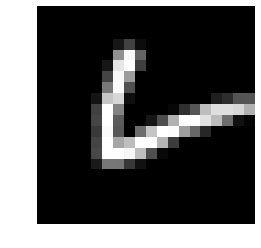

In [8]:
example = np.random.randint(0, X.shape[0] + 1)
pred = model.Predict(X[example])
if pred == 10:
    pred = 0
print("Predicted digit: ", pred)
ShowPred(X[example])